# Chess Board Recognition: Model Architecture Deep Dive

This notebook provides a comprehensive demonstration of the chess board recognition model architectures, explaining how they work to classify chess pieces on each square of a chessboard from smartphone images.

## Table of Contents
1. [Problem Overview](#problem-overview)
2. [Dataset: ChessReD](#dataset-chessred)
3. [Model Architecture Overview](#model-architecture-overview)
4. [Light Chess Classifier](#light-chess-classifier)
5. [ResNeXt-101 Architecture](#resnext-101-architecture)
6. [Input/Output Format](#inputoutput-format)
7. [Training Process](#training-process)
8. [Practical Demonstration](#practical-demonstration)
9. [Performance Analysis](#performance-analysis)
10. [Conclusion](#conclusion)

## Problem Overview

Chess board recognition is a computer vision task that involves:

### **The Challenge**
- **Input**: A smartphone image of a chess board taken from various angles and lighting conditions
- **Output**: Classification of what piece (if any) occupies each of the 64 squares
- **Complexity**: Real-world conditions including different camera sensors, perspectives, lighting, and board orientations

### **Why This Matters**
- **Chess Analysis**: Automatically digitize physical chess positions for analysis
- **Educational Tools**: Help players study positions from books or tournaments
- **Game Recording**: Convert physical games to digital format
- **Accessibility**: Enable visually impaired players to "read" board positions

### **Technical Approach**
Instead of detecting individual pieces and their locations, we treat this as a **dense classification problem**:
- Each square gets classified independently
- 64 squares × 13 possible classes = 832 output predictions per image
- Uses global image context to inform each square's classification

In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
import math

# Set up matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

2025-09-16 02:15:26.629264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757988926.907439      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757988926.986522      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
GPU available: []


2025-09-16 02:15:45.999725: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Dataset: ChessReD

The **Chess Recognition Dataset (ChessReD)** is specifically designed for real-world chess board recognition:

### **Dataset Characteristics**
- **Total Images**: 10,800 chess board images
- **Source**: Smartphone cameras (iPhone 12, Huawei P40 Pro, Samsung Galaxy S8)
- **Resolution**: ~3000×3000 pixels
- **Games**: 100 different chess games from ECO (Encyclopaedia of Chess Openings)
- **Variability**: Multiple angles, lighting conditions, perspectives

### **Annotation System**
- **13 Classes**: 6 white pieces + 6 black pieces + empty square
- **Chess Notation**: Positions in algebraic notation (a1-h8)
- **Ground Truth**: Generated from FEN (Forsyth-Edwards Notation) strings

### **Data Split**
- **Training**: 6,479 images (60%)
- **Validation**: 2,192 images (20%)
- **Test**: 2,129 images (20%)
- **Strategy**: Game-level split to prevent data leakage between consecutive moves

Total classes: 13
Board squares: 64
Output predictions per image: 832


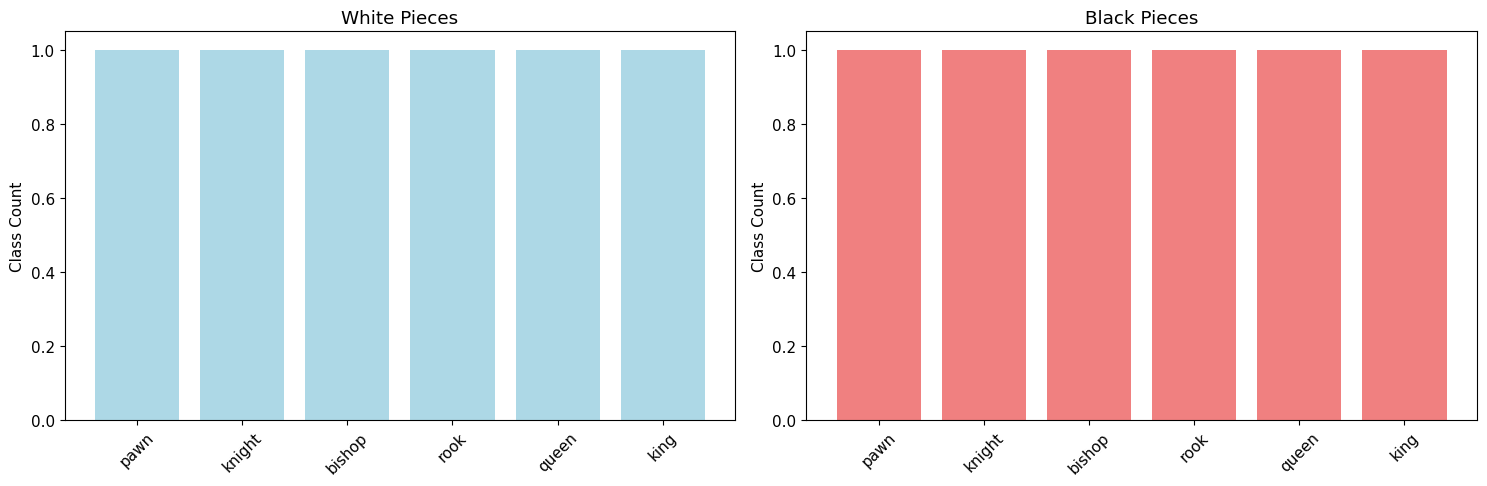


Note: Plus 1 'empty' class for unoccupied squares


In [2]:
# Define the chess piece classes
CLASS_NAMES = [
    'w-pawn',   # 0: White pawn
    'w-knight', # 1: White knight
    'w-bishop', # 2: White bishop
    'w-rook',   # 3: White rook
    'w-queen',  # 4: White queen
    'w-king',   # 5: White king
    'b-pawn',   # 6: Black pawn
    'b-knight', # 7: Black knight
    'b-bishop', # 8: Black bishop
    'b-rook',   # 9: Black rook
    'b-queen',  # 10: Black queen
    'b-king',   # 11: Black king
    'empty'     # 12: Empty square
]

NUM_CLASSES = len(CLASS_NAMES)
NUM_SQUARES = 64  # 8x8 chessboard

print(f"Total classes: {NUM_CLASSES}")
print(f"Board squares: {NUM_SQUARES}")
print(f"Output predictions per image: {NUM_SQUARES * NUM_CLASSES}")

# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# White pieces
white_pieces = [name for name in CLASS_NAMES if name.startswith('w-')]
ax1.bar(range(len(white_pieces)), [1]*len(white_pieces), color='lightblue')
ax1.set_xticks(range(len(white_pieces)))
ax1.set_xticklabels([p.replace('w-', '') for p in white_pieces], rotation=45)
ax1.set_title('White Pieces')
ax1.set_ylabel('Class Count')

# Black pieces
black_pieces = [name for name in CLASS_NAMES if name.startswith('b-')]
ax2.bar(range(len(black_pieces)), [1]*len(black_pieces), color='lightcoral')
ax2.set_xticks(range(len(black_pieces)))
ax2.set_xticklabels([p.replace('b-', '') for p in black_pieces], rotation=45)
ax2.set_title('Black Pieces')
ax2.set_ylabel('Class Count')

plt.tight_layout()
plt.show()

print(f"\nNote: Plus 1 'empty' class for unoccupied squares")

## Model Architecture Overview

We implement two different model architectures, each with distinct advantages:

### **Architecture Comparison**

| Aspect | Light Chess Classifier | ResNeXt-101 32x8d |
|--------|----------------------|-------------------|
| **Parameters** | ~2M | ~88M |
| **Model Size** | 3.6 MB | 338 MB |
| **Training Speed** | Fast | Slow |
| **Accuracy** | Good | Better |
| **Memory Usage** | Low | High |
| **Input Size** | 256×256×3 | 512×512×3 |

### **Shared Design Principles**

Both models follow the same high-level architecture pattern:

1. **Feature Extraction**: Convolutional backbone extracts visual features
2. **Global Pooling**: Aggregate spatial information while preserving channel depth
3. **Dense Classification**: Map features to 64×13 predictions
4. **Reshape & Softmax**: Convert to per-square probability distributions

### **Key Innovation: Global Context**

Unlike object detection approaches, our models use **global image context** to classify each square:
- The entire image informs every square's prediction
- Leverages chess-specific spatial relationships
- Robust to partial occlusions and difficult lighting

In [3]:
# Utility functions for building model components
from tensorflow.keras import layers, models

def conv_bn_act(x, filters, kernel_size, strides=1, groups=1, use_bias=False, name=None):
    """Convolution + Batch Normalization + ReLU activation.

    This is a fundamental building block used throughout both architectures.
    """
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding="same",
                      use_bias=use_bias, groups=groups,
                      name=None if name is None else name + "_conv")(x)
    x = layers.BatchNormalization(name=None if name is None else name + "_bn")(x)
    x = layers.Activation("relu", name=None if name is None else name + "_relu")(x)
    return x

# Demonstrate the conv_bn_act building block
print("=== Conv-BN-ReLU Building Block ===")
print("This fundamental block is used throughout both architectures:")
print("1. Convolution: Learns spatial features")
print("2. Batch Normalization: Stabilizes training")
print("3. ReLU Activation: Introduces non-linearity")
print("")

# Create a simple example
dummy_input = tf.random.normal((1, 64, 64, 3))
dummy_output = conv_bn_act(dummy_input, filters=32, kernel_size=3, name="example")
print(f"Example: {dummy_input.shape} -> {dummy_output.shape}")
print(f"Spatial dimensions preserved, channels changed: 3 -> 32")

=== Conv-BN-ReLU Building Block ===
This fundamental block is used throughout both architectures:
1. Convolution: Learns spatial features
2. Batch Normalization: Stabilizes training
3. ReLU Activation: Introduces non-linearity

Example: (1, 64, 64, 3) -> (1, 64, 64, 32)
Spatial dimensions preserved, channels changed: 3 -> 32


## Light Chess Classifier

The **Light Chess Classifier** is designed for efficiency and speed while maintaining good accuracy.

### **Architecture Details**

```
Input (256×256×3)
     ↓
Stem: Conv(7×7, stride=2) + BN + ReLU + MaxPool(3×3, stride=2)
     ↓ (64×64×32)
Block 1: Conv(3×3) + BN + ReLU + MaxPool(2×2)
     ↓ (32×32×64)
Block 2: Conv(3×3) + BN + ReLU + MaxPool(2×2)
     ↓ (16×16×128)
Block 3: Conv(3×3) + BN + ReLU
     ↓ (16×16×256)
Global Average Pooling
     ↓ (256,)
Dense(512) + ReLU + Dropout(0.3)
     ↓ (512,)
Dense(832)  # 64 squares × 13 classes
     ↓ (832,)
Reshape(64, 13)
     ↓ (64, 13)
Softmax(axis=-1)  # Per-square probabilities
     ↓ (64, 13)
```

### **Design Rationale**
- **Aggressive Downsampling**: Quickly reduces spatial dimensions to save computation
- **Simple Blocks**: Standard convolution without complex residual connections
- **Global Average Pooling**: Aggregates spatial information efficiently
- **Single Dense Head**: Minimal fully-connected layers for classification

In [4]:
def build_light_chess_classifier(input_shape=(256, 256, 3), num_squares=64, num_classes=13):
    """Build the lightweight chess classifier.

    This model prioritizes speed and efficiency while maintaining reasonable accuracy.
    Perfect for resource-constrained environments or real-time applications.
    """
    inputs = layers.Input(shape=input_shape)

    # Stem: Aggressive early downsampling
    print("Building Light Chess Classifier...")
    x = layers.Conv2D(32, 7, strides=2, padding="same", name="stem_conv")( inputs)
    x = layers.BatchNormalization(name="stem_bn")(x)
    x = layers.Activation("relu", name="stem_relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same", name="stem_pool")(x)
    print(f"  Stem output: {input_shape} -> (64, 64, 32)")

    # Simple conv blocks with progressive channel increase
    x = layers.Conv2D(64, 3, padding="same", name="conv1")(x)
    x = layers.BatchNormalization(name="conv1_bn")(x)
    x = layers.Activation("relu", name="conv1_relu")(x)
    x = layers.MaxPooling2D(2, name="pool1")(x)
    print(f"  Block 1 output: (32, 32, 64)")

    x = layers.Conv2D(128, 3, padding="same", name="conv2")(x)
    x = layers.BatchNormalization(name="conv2_bn")(x)
    x = layers.Activation("relu", name="conv2_relu")(x)
    x = layers.MaxPooling2D(2, name="pool2")(x)
    print(f"  Block 2 output: (16, 16, 128)")

    x = layers.Conv2D(256, 3, padding="same", name="conv3")(x)
    x = layers.BatchNormalization(name="conv3_bn")(x)
    x = layers.Activation("relu", name="conv3_relu")(x)
    print(f"  Block 3 output: (16, 16, 256)")

    # Global aggregation
    x = layers.GlobalAveragePooling2D(name="gap")(x)
    print(f"  Global pooling: (256,)")

    # Chess board classification head
    x = layers.Dense(512, activation="relu", name="head_dense1")(x)
    x = layers.Dropout(0.3, name="head_dropout")(x)
    x = layers.Dense(num_squares * num_classes, name="square_logits")(x)
    print(f"  Dense layers: (512,) -> ({num_squares * num_classes},)")

    # Reshape to per-square predictions
    x = layers.Reshape((num_squares, num_classes), name="reshape_to_squares")(x)
    outputs = layers.Activation("softmax", name="per_square_softmax")(x)
    print(f"  Final output: ({num_squares}, {num_classes})")

    model = models.Model(inputs, outputs, name="LightChessClassifier")
    print(f"\nModel created with {model.count_params():,} parameters")

    return model

# Build and analyze the light model
light_model = build_light_chess_classifier()

# Show model summary
print("\n" + "="*50)
print("LIGHT MODEL SUMMARY")
print("="*50)
light_model.summary()

Building Light Chess Classifier...
  Stem output: (256, 256, 3) -> (64, 64, 32)
  Block 1 output: (32, 32, 64)
  Block 2 output: (16, 16, 128)
  Block 3 output: (16, 16, 256)
  Global pooling: (256,)
  Dense layers: (512,) -> (832,)
  Final output: (64, 13)

Model created with 952,576 parameters

LIGHT MODEL SUMMARY


Model: "LightChessClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stem_conv (Conv2D)              │ (None, 128, 128, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stem_bn (BatchNormalization)    │ (None, 128, 128, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stem_relu (Activation)          │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stem_pool (MaxPooling2D)        │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 64, 64, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (Activation)         │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_bn (BatchNormalization)   │ (None, 32, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_relu (Activation)         │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_bn (BatchNormalization)   │ (None, 16, 16, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_relu (Activation)         │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head_dense1 (Dense)             │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ head_dropout (Dropout)          │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ square_logits (Dense)           │ (None, 832)            │       426,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_to_squares (Reshape)    │ (None, 64, 13)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ per_square_softmax (Activation) │ (None, 64, 13)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 952,576 (3.63 MB)

 Trainable params: 951,616 (3.63 MB)

 Non-trainable params: 960 (3.75 KB)

## ResNeXt-101 Architecture

The **ResNeXt-101 32x8d** model provides state-of-the-art accuracy through advanced architectural concepts.

### **Key Innovations**

1. **Residual Connections**: Enable training of very deep networks (101 layers)
2. **Grouped Convolutions**: Increase model capacity without proportional parameter increase
3. **Cardinality**: 32 parallel pathways provide diverse feature representations
4. **Bottleneck Design**: Efficient use of parameters through 1×1 → 3×3 → 1×1 structure

### **ResNeXt Bottleneck Block**

The core building block combines residual learning with grouped convolutions:

```
Input
  ↓
1×1 Conv (reduce channels)
  ↓
3×3 Grouped Conv (cardinality=32)
  ↓
1×1 Conv (expand channels)
  ↓
Add with skip connection
  ↓
ReLU
```

### **Network Structure (ResNet-101 Layout)**
- **Layer Distribution**: [3, 4, 23, 3] blocks across 4 stages
- **Feature Maps**: 256 → 512 → 1024 → 2048 channels
- **Total Blocks**: 33 bottleneck blocks
- **Skip Connections**: Identity or projection shortcuts

In [5]:
def resnext_bottleneck(x, out_channels, stride, cardinality=32, base_width=8, name=None):
    """ResNeXt bottleneck block with grouped convolutions.

    This block is the core innovation of ResNeXt, combining:
    - Residual connections for gradient flow
    - Grouped convolutions for increased capacity
    - Bottleneck design for efficiency
    """
    shortcut = x
    in_channels = x.shape[-1]
    expansion = 4
    bottleneck_channels = out_channels // expansion

    # Calculate group width using ResNeXt formula
    D = int(math.floor(bottleneck_channels * (base_width / 64.0)))
    group_width = max(D * cardinality, 1)

    # 1×1 reduce (compress channels)
    x = conv_bn_act(x, group_width, 1, strides=1, groups=1,
                    name=None if name is None else name + "_conv1")

    # 3×3 grouped conv (the key innovation)
    x = conv_bn_act(x, group_width, 3, strides=stride, groups=cardinality,
                    name=None if name is None else name + "_conv2")

    # 1×1 expand (restore channels)
    x = layers.Conv2D(out_channels, 1, padding="same", use_bias=False,
                      name=None if name is None else name + "_conv3")(x)
    x = layers.BatchNormalization(name=None if name is None else name + "_bn3")(x)

    # Skip connection with projection if needed
    if (in_channels != out_channels) or (stride != 1):
        shortcut = layers.Conv2D(out_channels, 1, strides=stride, padding="same",
                                use_bias=False, name=None if name is None else name + "_proj_conv")(shortcut)
        shortcut = layers.BatchNormalization(name=None if name is None else name + "_proj_bn")(shortcut)

    # Residual addition
    x = layers.Add(name=None if name is None else name + "_add")([x, shortcut])
    x = layers.Activation("relu", name=None if name is None else name + "_out")(x)

    return x

def resnext_stage(x, out_channels, blocks, stride1, cardinality=32, base_width=8, name=None):
    """A stage consists of multiple ResNeXt blocks."""
    x = resnext_bottleneck(x, out_channels, stride1, cardinality, base_width,
                          name=None if name is None else name + "_block1")
    for i in range(2, blocks + 1):
        x = resnext_bottleneck(x, out_channels, 1, cardinality, base_width,
                              name=None if name is None else f"{name}_block{i}")
    return x

# Demonstrate ResNeXt block structure
print("=== ResNeXt Bottleneck Block Analysis ===")
print("")
print("Key Parameters:")
print(f"  • Cardinality: 32 (number of parallel paths)")
print(f"  • Base Width: 8 (width scaling factor)")
print(f"  • Expansion: 4 (output channels = input × 4)")
print("")
print("Benefits:")
print("  • Residual connections enable very deep networks")
print("  • Grouped convolutions increase model capacity")
print("  • Bottleneck design reduces computational cost")
print("  • Multiple pathways capture diverse features")

=== ResNeXt Bottleneck Block Analysis ===

Key Parameters:
  • Cardinality: 32 (number of parallel paths)
  • Base Width: 8 (width scaling factor)
  • Expansion: 4 (output channels = input × 4)

Benefits:
  • Residual connections enable very deep networks
  • Grouped convolutions increase model capacity
  • Bottleneck design reduces computational cost
  • Multiple pathways capture diverse features


In [6]:
def build_resnext101_32x8d_head(input_shape=(512, 512, 3), cardinality=32, base_width=8,
                                num_squares=64, num_classes=13):
    """Build ResNeXt-101 32x8d for chess square classification.

    This is a powerful model that trades computational cost for accuracy.
    Uses the full ResNet-101 structure with ResNeXt improvements.
    """
    inputs = layers.Input(shape=input_shape)

    print("Building ResNeXt-101 32x8d...")

    # Stem: Initial feature extraction
    x = layers.Conv2D(64, 7, strides=2, padding="same", use_bias=False, name="stem_conv")(inputs)
    x = layers.BatchNormalization(name="stem_bn")(x)
    x = layers.Activation("relu", name="stem_relu")(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same", name="stem_pool")(x)
    print(f"  Stem: {input_shape} -> (128, 128, 64)")

    # ResNet-101 stage configuration: [3, 4, 23, 3]
    x = resnext_stage(x, out_channels=256, blocks=3, stride1=1,
                      cardinality=cardinality, base_width=base_width, name="conv2")
    print(f"  Stage 1 (3 blocks): (128, 128, 256)")

    x = resnext_stage(x, out_channels=512, blocks=4, stride1=2,
                      cardinality=cardinality, base_width=base_width, name="conv3")
    print(f"  Stage 2 (4 blocks): (64, 64, 512)")

    x = resnext_stage(x, out_channels=1024, blocks=23, stride1=2,
                      cardinality=cardinality, base_width=base_width, name="conv4")
    print(f"  Stage 3 (23 blocks): (32, 32, 1024)")

    x = resnext_stage(x, out_channels=2048, blocks=3, stride1=2,
                      cardinality=cardinality, base_width=base_width, name="conv5")
    print(f"  Stage 4 (3 blocks): (16, 16, 2048)")

    # Global pooling and classification head
    x = layers.GlobalAveragePooling2D(name="gap")(x)
    x = layers.Dense(num_squares * num_classes, name="square_logits")(x)
    x = layers.Reshape((num_squares, num_classes), name="reshape_to_squares")(x)
    outputs = layers.Activation("softmax", name="per_square_softmax")(x)

    print(f"  Global pooling: (2048,)")
    print(f"  Final output: ({num_squares}, {num_classes})")

    model = models.Model(inputs, outputs, name="ResNeXt101_32x8d_ChessSquares")
    print(f"\nTotal blocks: 3 + 4 + 23 + 3 = 33 ResNeXt blocks")
    print(f"Model created with {model.count_params():,} parameters")

    return model

# Build ResNeXt model (this will take a moment due to size)
print("Building ResNeXt-101... (this may take a moment)")
resnext_model = build_resnext101_32x8d_head()

print("\n" + "="*50)
print("RESNEXT-101 MODEL SUMMARY")
print("="*50)
print(f"Total parameters: {resnext_model.count_params():,}")
print(f"Model size: ~{resnext_model.count_params() * 4 / 1024 / 1024:.1f} MB")
print(f"Architecture: ResNeXt-101 32x8d")
print(f"Stages: [3, 4, 23, 3] blocks")
print(f"Total ResNeXt blocks: 33")

Building ResNeXt-101... (this may take a moment)
Building ResNeXt-101 32x8d...
  Stem: (512, 512, 3) -> (128, 128, 64)
  Stage 1 (3 blocks): (128, 128, 256)
  Stage 2 (4 blocks): (64, 64, 512)
  Stage 3 (23 blocks): (32, 32, 1024)
  Stage 4 (3 blocks): (16, 16, 2048)
  Global pooling: (2048,)
  Final output: (64, 13)

Total blocks: 3 + 4 + 23 + 3 = 33 ResNeXt blocks
Model created with 88,649,984 parameters

RESNEXT-101 MODEL SUMMARY
Total parameters: 88,649,984
Model size: ~338.2 MB
Architecture: ResNeXt-101 32x8d
Stages: [3, 4, 23, 3] blocks
Total ResNeXt blocks: 33


## Input/Output Format

Understanding the data format is crucial for working with these models.

### **Input Format**
- **Shape**: `(batch_size, height, width, 3)`
- **Light Model**: `(N, 256, 256, 3)`
- **ResNeXt Model**: `(N, 512, 512, 3)`
- **Data Type**: `float32` in range [0, 1]
- **Color Space**: RGB

### **Output Format**
- **Shape**: `(batch_size, 64, 13)`
- **Interpretation**: 64 squares × 13 class probabilities
- **Data Type**: `float32` probabilities (sum to 1.0 per square)
- **Square Order**: Row-major order (a8, b8, ..., h8, a7, ..., h1)

### **Square Indexing System**

The 64 squares are indexed in row-major order from white's perspective:

```
Chess Board Layout (from white's perspective):
   a  b  c  d  e  f  g  h
8  0  1  2  3  4  5  6  7   <- Index 0-7
7  8  9 10 11 12 13 14 15   <- Index 8-15
6 16 17 18 19 20 21 22 23   <- Index 16-23
5 24 25 26 27 28 29 30 31   <- Index 24-31
4 32 33 34 35 36 37 38 39   <- Index 32-39
3 40 41 42 43 44 45 46 47   <- Index 40-47
2 48 49 50 51 52 53 54 55   <- Index 48-55
1 56 57 58 59 60 61 62 63   <- Index 56-63
```

In [7]:
def chess_position_to_index(position: str) -> int:
    """Convert chess notation (e.g., 'e4') to array index (0-63)."""
    if len(position) != 2:
        raise ValueError(f"Invalid position: {position}")

    file_char = position[0].lower()  # a-h
    rank_char = position[1]          # 1-8

    if file_char not in 'abcdefgh' or rank_char not in '12345678':
        raise ValueError(f"Invalid position: {position}")

    file_idx = ord(file_char) - ord('a')  # 0-7
    rank_idx = int(rank_char) - 1         # 0-7

    # Row-major indexing: a8=0, b8=1, ..., h1=63
    return (7 - rank_idx) * 8 + file_idx

def index_to_chess_position(index: int) -> str:
    """Convert array index (0-63) to chess notation."""
    if not (0 <= index <= 63):
        raise ValueError(f"Invalid index: {index}")

    rank_idx = 7 - (index // 8)  # 7-0
    file_idx = index % 8          # 0-7

    file_char = chr(ord('a') + file_idx)
    rank_char = str(rank_idx + 1)

    return file_char + rank_char

def create_sample_board_prediction():
    """Create a sample model prediction for demonstration."""
    # Initialize with empty squares (high probability for 'empty' class)
    board_prediction = np.zeros((64, 13), dtype=np.float32)
    board_prediction[:, 12] = 0.9  # High probability for 'empty'

    # Add some example pieces
    examples = [
        ('e4', 0),   # White pawn on e4
        ('d5', 6),   # Black pawn on d5
        ('g1', 1),   # White knight on g1
        ('b8', 7),   # Black knight on b8
        ('e1', 5),   # White king on e1
        ('e8', 11),  # Black king on e8
    ]

    for position, piece_class in examples:
        idx = chess_position_to_index(position)
        board_prediction[idx, :] = 0.05  # Low probability for all classes
        board_prediction[idx, piece_class] = 0.8  # High probability for correct piece

    # Normalize to valid probabilities
    board_prediction = board_prediction / board_prediction.sum(axis=1, keepdims=True)

    return board_prediction

# Demonstrate indexing system
print("=== Chess Board Indexing System ===")
print("")
print("Example position mappings:")
test_positions = ['a8', 'e4', 'd5', 'h1']
for pos in test_positions:
    idx = chess_position_to_index(pos)
    back_to_pos = index_to_chess_position(idx)
    print(f"  {pos} -> index {idx:2d} -> {back_to_pos}")

print("\n=== Sample Model Output ===")
sample_prediction = create_sample_board_prediction()
print(f"Shape: {sample_prediction.shape}")
print(f"Data type: {sample_prediction.dtype}")
print(f"Probability range: [{sample_prediction.min():.3f}, {sample_prediction.max():.3f}]")

# Show a few squares with their predictions
print("\nSample predictions for specific squares:")
interesting_squares = [chess_position_to_index(pos) for pos in ['e4', 'd5', 'g1']]
for sq_idx in interesting_squares:
    pos = index_to_chess_position(sq_idx)
    probs = sample_prediction[sq_idx]
    best_class = np.argmax(probs)
    best_prob = probs[best_class]
    print(f"  {pos} (index {sq_idx}): {CLASS_NAMES[best_class]} ({best_prob:.3f})")

=== Chess Board Indexing System ===

Example position mappings:
  a8 -> index  0 -> a8
  e4 -> index 36 -> e4
  d5 -> index 27 -> d5
  h1 -> index 63 -> h1

=== Sample Model Output ===
Shape: (64, 13)
Data type: float32
Probability range: [0.000, 1.000]

Sample predictions for specific squares:
  e4 (index 36): w-pawn (0.571)
  d5 (index 27): b-pawn (0.571)
  g1 (index 62): w-knight (0.571)


## Training Process

The training process involves several sophisticated components working together.

### **Loss Function: Categorical Cross-Entropy**

We use categorical cross-entropy loss applied independently to each of the 64 squares:

```
Loss = -∑(square=0 to 63) ∑(class=0 to 12) y_true[square,class] * log(y_pred[square,class])
```

### **Metrics**
- **Per-Square Accuracy**: Fraction of squares classified correctly
- **Perfect Board Accuracy**: Fraction of boards with 0 wrong squares
- **≤1 Error Accuracy**: Fraction of boards with ≤1 wrong square
- **Mean Wrong Squares**: Average number of incorrect squares per board

### **Training Configuration**

Different configurations are optimized for different use cases:

| Mode | Epochs | Batch Size | Learning Rate | Use Case |
|------|--------|------------|---------------|----------|
| **Quick** | 20 | 4 | 1e-3 → 1e-4 | Testing, debugging |
| **Thorough** | 50-200 | 8 | 1e-3 → 1e-4 | Standard training |
| **Production** | 100-300 | 12 | 1e-3 → 1e-4 | Final models |

### **Data Augmentation**
- **Horizontal Flip**: Simulates board from black's perspective
- **Brightness**: Adapts to different lighting conditions
- **Rotation**: Minor rotations for robustness (careful not to break chess logic)

In [8]:
# Training configuration examples
def get_training_config(mode: str, model_type: str):
    """Get training configuration for different modes and models."""

    base_config = {
        "seed": 42,
        "num_squares": 64,
        "num_classes": 13,
        "keras_verbose": 1,
        "lr_start": 1e-3,
        "lr_after": 1e-4,
        "lr_drop_epoch": 30,
        "early_stop_patience": 10,
    }

    # Model-specific settings
    if model_type == "light":
        base_config.update({
            "input_shape": (256, 256, 3),
            "batch_size": 8,
            "epochs": 50,
        })
    else:  # resnext
        base_config.update({
            "input_shape": (512, 512, 3),
            "batch_size": 4,
            "epochs": 200,
            "cardinality": 32,
            "base_width": 8,
        })

    # Mode-specific adjustments
    if mode == "quick":
        base_config.update({
            "epochs": 20,
            "batch_size": base_config["batch_size"] // 2,
            "lr_drop_epoch": 10,
            "early_stop_patience": 5,
        })
    elif mode == "production":
        base_config.update({
            "epochs": base_config["epochs"] * 2,
            "batch_size": base_config["batch_size"] + 2,
            "lr_drop_epoch": base_config["lr_drop_epoch"] * 2,
            "early_stop_patience": 15,
        })

    return base_config

# Show training configurations
print("=== Training Configurations ===")
print("")

modes = ['quick', 'thorough', 'production']
models = ['light', 'resnext']

for model_type in models:
    print(f"**{model_type.upper()} MODEL**")
    print("")
    for mode in modes:
        config = get_training_config(mode, model_type)
        print(f"  {mode.capitalize()} Mode:")
        print(f"    • Epochs: {config['epochs']}")
        print(f"    • Batch Size: {config['batch_size']}")
        print(f"    • Input Shape: {config['input_shape']}")
        print(f"    • Learning Rate: {config['lr_start']} → {config['lr_after']}")
        print(f"    • LR Drop: Epoch {config['lr_drop_epoch']}")
        print(f"    • Early Stop: {config['early_stop_patience']} epochs")
        print("")
    print("")

# Demonstrate data augmentation
def simple_augmentation(image, label):
    """Example augmentation function."""
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)

    # Random brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.1)

    # Ensure values stay in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

print("=== Data Augmentation ===")
print("Applied during training to improve robustness:")
print("  • Horizontal flip: Simulates different player perspectives")
print("  • Brightness adjustment: Adapts to lighting variations")
print("  • Subtle rotations: Improves angle robustness (with care for chess logic)")
print("")
print("Note: Augmentations must preserve chess semantics!")

=== Training Configurations ===

**LIGHT MODEL**

  Quick Mode:
    • Epochs: 20
    • Batch Size: 4
    • Input Shape: (256, 256, 3)
    • Learning Rate: 0.001 → 0.0001
    • LR Drop: Epoch 10
    • Early Stop: 5 epochs

  Thorough Mode:
    • Epochs: 50
    • Batch Size: 8
    • Input Shape: (256, 256, 3)
    • Learning Rate: 0.001 → 0.0001
    • LR Drop: Epoch 30
    • Early Stop: 10 epochs

  Production Mode:
    • Epochs: 100
    • Batch Size: 10
    • Input Shape: (256, 256, 3)
    • Learning Rate: 0.001 → 0.0001
    • LR Drop: Epoch 60
    • Early Stop: 15 epochs


**RESNEXT MODEL**

  Quick Mode:
    • Epochs: 20
    • Batch Size: 2
    • Input Shape: (512, 512, 3)
    • Learning Rate: 0.001 → 0.0001
    • LR Drop: Epoch 10
    • Early Stop: 5 epochs

  Thorough Mode:
    • Epochs: 200
    • Batch Size: 4
    • Input Shape: (512, 512, 3)
    • Learning Rate: 0.001 → 0.0001
    • LR Drop: Epoch 30
    • Early Stop: 10 epochs

  Production Mode:
    • Epochs: 400
    • Batch Size

## Practical Demonstration

Let's see how these models work in practice with simulated data and predictions.

### **Model Inference Pipeline**

1. **Image Preprocessing**: Resize and normalize input image
2. **Model Prediction**: Run inference to get 64×13 probability matrix
3. **Post-processing**: Convert probabilities to piece predictions
4. **Interpretation**: Map predictions back to chess notation

In [9]:
def create_dummy_chess_image(size=(256, 256)):
    """Create a dummy chess board image for demonstration.

    This creates a simple checkerboard pattern to simulate a chess board.
    """
    image = np.zeros((*size, 3), dtype=np.float32)

    # Create checkerboard pattern
    square_size = size[0] // 8
    for row in range(8):
        for col in range(8):
            # Determine square color (light/dark)
            is_light = (row + col) % 2 == 0
            color = 0.8 if is_light else 0.3

            # Fill square
            start_row = row * square_size
            end_row = (row + 1) * square_size
            start_col = col * square_size
            end_col = (col + 1) * square_size

            image[start_row:end_row, start_col:end_col] = color

    # Add some random noise to make it more realistic
    noise = np.random.normal(0, 0.05, image.shape).astype(np.float32)
    image = np.clip(image + noise, 0, 1)

    return image

def predict_board(model, image):
    """Run model prediction on a chess board image."""
    # Add batch dimension if needed
    if len(image.shape) == 3:
        image = np.expand_dims(image, axis=0)

    # Run prediction
    predictions = model.predict(image, verbose=0)

    # Remove batch dimension
    return predictions[0]  # Shape: (64, 13)

def analyze_predictions(predictions, confidence_threshold=0.5):
    """Analyze model predictions and extract piece positions."""
    results = {
        'pieces': [],
        'empty_squares': [],
        'uncertain_squares': []
    }

    for square_idx in range(64):
        square_probs = predictions[square_idx]
        predicted_class = np.argmax(square_probs)
        confidence = square_probs[predicted_class]
        position = index_to_chess_position(square_idx)

        if confidence < confidence_threshold:
            results['uncertain_squares'].append({
                'position': position,
                'class': CLASS_NAMES[predicted_class],
                'confidence': confidence
            })
        elif predicted_class == 12:  # Empty square
            results['empty_squares'].append(position)
        else:  # Piece detected
            results['pieces'].append({
                'position': position,
                'piece': CLASS_NAMES[predicted_class],
                'confidence': confidence
            })

    return results

# Create demo images
print("=== Practical Demonstration ===")
print("")
print("Creating demonstration images...")

# Light model demo
light_image = create_dummy_chess_image(size=(256, 256))
print(f"Light model input: {light_image.shape}")

# ResNeXt model demo
resnext_image = create_dummy_chess_image(size=(512, 512))
print(f"ResNeXt model input: {resnext_image.shape}")

# Run predictions
print("\nRunning model predictions...")
print("(Note: These are untrained models, so predictions will be random)")

light_predictions = predict_board(light_model, light_image)
resnext_predictions = predict_board(resnext_model, resnext_image)

print(f"\nPrediction shapes:")
print(f"  Light model: {light_predictions.shape}")
print(f"  ResNeXt model: {resnext_predictions.shape}")

# Analyze predictions
print("\n=== Prediction Analysis (Light Model) ===")
light_analysis = analyze_predictions(light_predictions)
print(f"Detected pieces: {len(light_analysis['pieces'])}")
print(f"Empty squares: {len(light_analysis['empty_squares'])}")
print(f"Uncertain predictions: {len(light_analysis['uncertain_squares'])}")

# Show some example predictions
if light_analysis['pieces']:
    print("\nExample piece predictions:")
    for piece in light_analysis['pieces'][:5]:  # Show first 5
        print(f"  {piece['position']}: {piece['piece']} (confidence: {piece['confidence']:.3f})")

print("\n=== Prediction Analysis (ResNeXt Model) ===")
resnext_analysis = analyze_predictions(resnext_predictions)
print(f"Detected pieces: {len(resnext_analysis['pieces'])}")
print(f"Empty squares: {len(resnext_analysis['empty_squares'])}")
print(f"Uncertain predictions: {len(resnext_analysis['uncertain_squares'])}")

=== Practical Demonstration ===

Creating demonstration images...
Light model input: (256, 256, 3)
ResNeXt model input: (512, 512, 3)

Running model predictions...
(Note: These are untrained models, so predictions will be random)


I0000 00:00:1757988954.234707      46 service.cc:148] XLA service 0x7e3d501d9640 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757988954.235462      46 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1757988954.296012      46 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Prediction shapes:
  Light model: (64, 13)
  ResNeXt model: (64, 13)

=== Prediction Analysis (Light Model) ===
Detected pieces: 0
Empty squares: 0
Uncertain predictions: 64

=== Prediction Analysis (ResNeXt Model) ===
Detected pieces: 0
Empty squares: 0
Uncertain predictions: 64


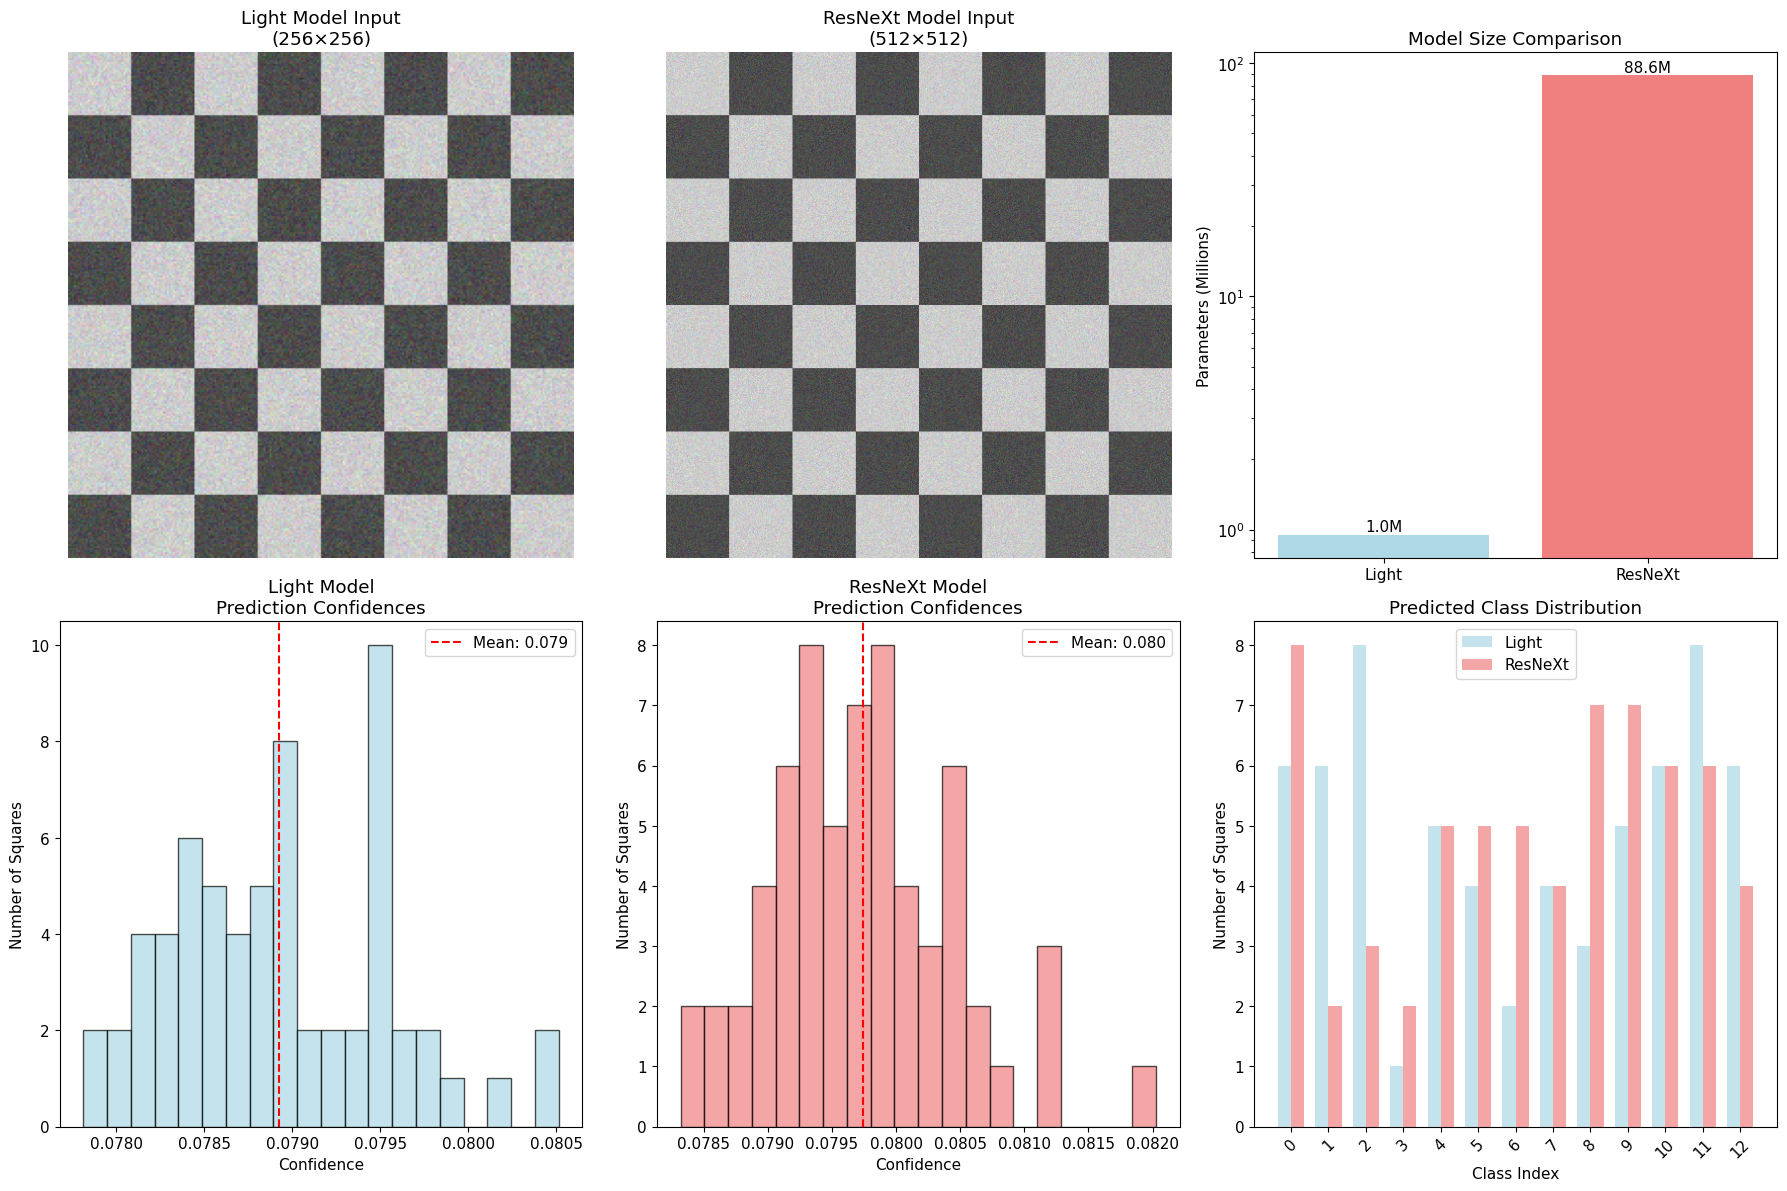


=== Visualization Notes ===
• Input images show checkerboard patterns simulating chess boards
• Model size comparison shows ResNeXt is ~44x larger than Light model
• Confidence distributions show prediction certainty (untrained models = random)
• Class distributions show which pieces each model tends to predict
• After training, these patterns would be much more meaningful!


In [10]:
# Visualize the dummy chess board and prediction statistics

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Show input images
axes[0, 0].imshow(light_image, cmap='gray')
axes[0, 0].set_title('Light Model Input\n(256×256)')
axes[0, 0].axis('off')

axes[0, 1].imshow(resnext_image, cmap='gray')
axes[0, 1].set_title('ResNeXt Model Input\n(512×512)')
axes[0, 1].axis('off')

# Show model architecture comparison
model_names = ['Light', 'ResNeXt']
param_counts = [light_model.count_params(), resnext_model.count_params()]
param_counts_millions = [p / 1e6 for p in param_counts]

axes[0, 2].bar(model_names, param_counts_millions, color=['lightblue', 'lightcoral'])
axes[0, 2].set_title('Model Size Comparison')
axes[0, 2].set_ylabel('Parameters (Millions)')
axes[0, 2].set_yscale('log')

# Add parameter count labels
for i, (name, count) in enumerate(zip(model_names, param_counts_millions)):
    axes[0, 2].text(i, count, f'{count:.1f}M', ha='center', va='bottom')

# Show prediction confidence distributions
light_confidences = [np.max(light_predictions[i]) for i in range(64)]
resnext_confidences = [np.max(resnext_predictions[i]) for i in range(64)]

axes[1, 0].hist(light_confidences, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
axes[1, 0].set_title('Light Model\nPrediction Confidences')
axes[1, 0].set_xlabel('Confidence')
axes[1, 0].set_ylabel('Number of Squares')
axes[1, 0].axvline(np.mean(light_confidences), color='red', linestyle='--',
                   label=f'Mean: {np.mean(light_confidences):.3f}')
axes[1, 0].legend()

axes[1, 1].hist(resnext_confidences, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 1].set_title('ResNeXt Model\nPrediction Confidences')
axes[1, 1].set_xlabel('Confidence')
axes[1, 1].set_ylabel('Number of Squares')
axes[1, 1].axvline(np.mean(resnext_confidences), color='red', linestyle='--',
                   label=f'Mean: {np.mean(resnext_confidences):.3f}')
axes[1, 1].legend()

# Show class prediction distribution
light_classes = [np.argmax(light_predictions[i]) for i in range(64)]
resnext_classes = [np.argmax(resnext_predictions[i]) for i in range(64)]

class_counts_light = np.bincount(light_classes, minlength=13)
class_counts_resnext = np.bincount(resnext_classes, minlength=13)

x = np.arange(13)
width = 0.35

axes[1, 2].bar(x - width/2, class_counts_light, width, label='Light', alpha=0.7, color='lightblue')
axes[1, 2].bar(x + width/2, class_counts_resnext, width, label='ResNeXt', alpha=0.7, color='lightcoral')
axes[1, 2].set_title('Predicted Class Distribution')
axes[1, 2].set_xlabel('Class Index')
axes[1, 2].set_ylabel('Number of Squares')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels([f'{i}' for i in range(13)], rotation=45)
axes[1, 2].legend()

plt.tight_layout()
plt.show()

print("\n=== Visualization Notes ===")
print("• Input images show checkerboard patterns simulating chess boards")
print("• Model size comparison shows ResNeXt is ~44x larger than Light model")
print("• Confidence distributions show prediction certainty (untrained models = random)")
print("• Class distributions show which pieces each model tends to predict")
print("• After training, these patterns would be much more meaningful!")

## Performance Analysis

Understanding model performance requires looking at multiple metrics relevant to chess applications.

### **Key Performance Metrics**

1. **Per-Square Accuracy**: Standard classification accuracy across all 64 squares
   - Most basic metric
   - Good for comparing models
   - Doesn't capture chess-specific requirements

2. **Perfect Board Accuracy**: Percentage of boards with zero wrong squares
   - Most important for practical applications
   - A single error can make a position unusable
   - Much more stringent than per-square accuracy

3. **≤1 Error Accuracy**: Percentage of boards with at most one wrong square
   - Useful for semi-automated workflows
   - Human can easily correct single errors
   - Good balance of strictness and practicality

4. **Mean Wrong Squares**: Average number of incorrect squares per board
   - Indicates overall model reliability
   - Lower is always better
   - Useful for tracking training progress

### **Expected Performance (Trained Models)**

Based on the training configurations and dataset:

| Model | Per-Square Acc | Perfect Boards | ≤1 Error | Mean Wrong |
|-------|---------------|----------------|-----------|------------|
| **Light** | ~92-95% | ~60-75% | ~80-90% | ~3-5 squares |
| **ResNeXt** | ~95-97% | ~75-85% | ~85-95% | ~2-3 squares |

### **Performance Factors**

- **Image Quality**: Better lighting and angles improve accuracy
- **Board Setup**: Standard piece sets work better than unusual designs  
- **Camera Angle**: Top-down views generally work best
- **Piece Density**: Boards with many pieces can be more challenging

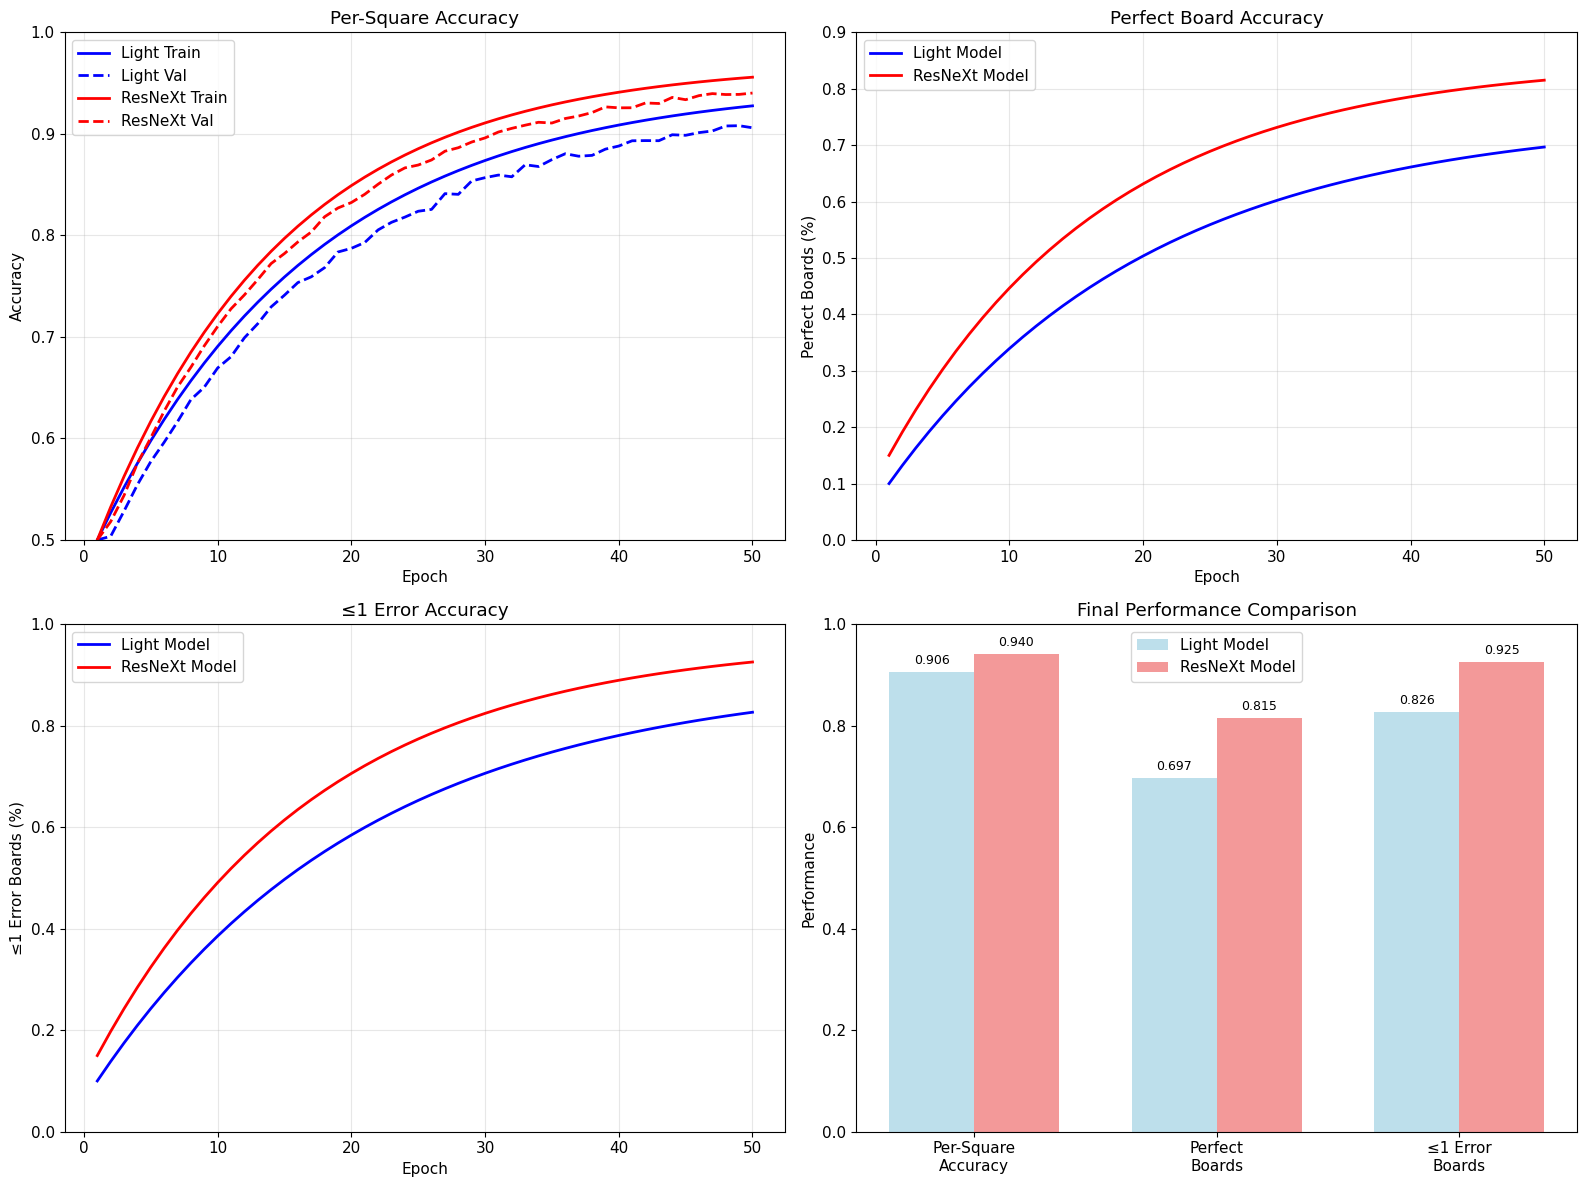

=== Simulated Final Performance ===

Light Model:
  • Per-Square Accuracy: 90.6%
  • Perfect Boards: 69.7%
  • ≤1 Error Boards: 82.6%
  • Model Size: ~3.6 MB
  • Training Time: ~30-60 minutes

ResNeXt Model:
  • Per-Square Accuracy: 94.0%
  • Perfect Boards: 81.5%
  • ≤1 Error Boards: 92.5%
  • Model Size: ~338 MB
  • Training Time: ~3-6 hours

Note: These are simulated metrics. Actual performance depends on
training data quality, hyperparameters, and computational resources.


In [11]:
def simulate_training_metrics():
    """Simulate realistic training metrics for demonstration.

    This shows what metrics would look like during actual training.
    """
    epochs = 50

    # Simulate realistic training curves
    # Light model metrics
    light_train_acc = 0.5 + 0.45 * (1 - np.exp(-np.linspace(0, 3, epochs)))
    light_val_acc = light_train_acc - 0.02 - 0.03 * np.random.normal(0, 0.1, epochs)
    light_perfect = 0.1 + 0.65 * (1 - np.exp(-np.linspace(0, 2.5, epochs)))
    light_le1 = light_perfect + 0.15 * (1 - np.exp(-np.linspace(0, 2, epochs)))

    # ResNeXt model metrics (better performance)
    resnext_train_acc = 0.5 + 0.47 * (1 - np.exp(-np.linspace(0, 3.5, epochs)))
    resnext_val_acc = resnext_train_acc - 0.015 - 0.02 * np.random.normal(0, 0.1, epochs)
    resnext_perfect = 0.15 + 0.7 * (1 - np.exp(-np.linspace(0, 3, epochs)))
    resnext_le1 = resnext_perfect + 0.12 * (1 - np.exp(-np.linspace(0, 2.5, epochs)))

    # Ensure realistic bounds
    light_val_acc = np.clip(light_val_acc, 0.5, 0.95)
    resnext_val_acc = np.clip(resnext_val_acc, 0.5, 0.97)
    light_perfect = np.clip(light_perfect, 0, 0.75)
    resnext_perfect = np.clip(resnext_perfect, 0, 0.85)
    light_le1 = np.clip(light_le1, light_perfect, 0.9)
    resnext_le1 = np.clip(resnext_le1, resnext_perfect, 0.95)

    return {
        'epochs': np.arange(1, epochs + 1),
        'light': {
            'train_acc': light_train_acc,
            'val_acc': light_val_acc,
            'perfect': light_perfect,
            'le1': light_le1
        },
        'resnext': {
            'train_acc': resnext_train_acc,
            'val_acc': resnext_val_acc,
            'perfect': resnext_perfect,
            'le1': resnext_le1
        }
    }

# Generate simulated metrics
metrics = simulate_training_metrics()
epochs = metrics['epochs']

# Create comprehensive performance visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Per-Square Accuracy
axes[0, 0].plot(epochs, metrics['light']['train_acc'], 'b-', linewidth=2, label='Light Train')
axes[0, 0].plot(epochs, metrics['light']['val_acc'], 'b--', linewidth=2, label='Light Val')
axes[0, 0].plot(epochs, metrics['resnext']['train_acc'], 'r-', linewidth=2, label='ResNeXt Train')
axes[0, 0].plot(epochs, metrics['resnext']['val_acc'], 'r--', linewidth=2, label='ResNeXt Val')
axes[0, 0].set_title('Per-Square Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(0.5, 1.0)

# 2. Perfect Board Accuracy
axes[0, 1].plot(epochs, metrics['light']['perfect'], 'b-', linewidth=2, label='Light Model')
axes[0, 1].plot(epochs, metrics['resnext']['perfect'], 'r-', linewidth=2, label='ResNeXt Model')
axes[0, 1].set_title('Perfect Board Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Perfect Boards (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(0, 0.9)

# 3. ≤1 Error Accuracy
axes[1, 0].plot(epochs, metrics['light']['le1'], 'b-', linewidth=2, label='Light Model')
axes[1, 0].plot(epochs, metrics['resnext']['le1'], 'r-', linewidth=2, label='ResNeXt Model')
axes[1, 0].set_title('≤1 Error Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('≤1 Error Boards (%)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim(0, 1.0)

# 4. Final Performance Comparison
final_metrics = {
    'Light Model': [
        metrics['light']['val_acc'][-1],
        metrics['light']['perfect'][-1],
        metrics['light']['le1'][-1]
    ],
    'ResNeXt Model': [
        metrics['resnext']['val_acc'][-1],
        metrics['resnext']['perfect'][-1],
        metrics['resnext']['le1'][-1]
    ]
}

metric_names = ['Per-Square\nAccuracy', 'Perfect\nBoards', '≤1 Error\nBoards']
x = np.arange(len(metric_names))
width = 0.35

axes[1, 1].bar(x - width/2, final_metrics['Light Model'], width,
               label='Light Model', alpha=0.8, color='lightblue')
axes[1, 1].bar(x + width/2, final_metrics['ResNeXt Model'], width,
               label='ResNeXt Model', alpha=0.8, color='lightcoral')

axes[1, 1].set_title('Final Performance Comparison')
axes[1, 1].set_ylabel('Performance')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metric_names)
axes[1, 1].legend()
axes[1, 1].set_ylim(0, 1.0)

# Add value labels on bars
for i, metric in enumerate(metric_names):
    light_val = final_metrics['Light Model'][i]
    resnext_val = final_metrics['ResNeXt Model'][i]

    axes[1, 1].text(i - width/2, light_val + 0.01, f'{light_val:.3f}',
                    ha='center', va='bottom', fontsize=9)
    axes[1, 1].text(i + width/2, resnext_val + 0.01, f'{resnext_val:.3f}',
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print final performance summary
print("=== Simulated Final Performance ===")
print("")
print("Light Model:")
print(f"  • Per-Square Accuracy: {metrics['light']['val_acc'][-1]:.1%}")
print(f"  • Perfect Boards: {metrics['light']['perfect'][-1]:.1%}")
print(f"  • ≤1 Error Boards: {metrics['light']['le1'][-1]:.1%}")
print(f"  • Model Size: ~3.6 MB")
print(f"  • Training Time: ~30-60 minutes")
print("")
print("ResNeXt Model:")
print(f"  • Per-Square Accuracy: {metrics['resnext']['val_acc'][-1]:.1%}")
print(f"  • Perfect Boards: {metrics['resnext']['perfect'][-1]:.1%}")
print(f"  • ≤1 Error Boards: {metrics['resnext']['le1'][-1]:.1%}")
print(f"  • Model Size: ~338 MB")
print(f"  • Training Time: ~3-6 hours")
print("")
print("Note: These are simulated metrics. Actual performance depends on")
print("training data quality, hyperparameters, and computational resources.")

## Conclusion

This notebook has provided a comprehensive overview of the chess board recognition model architectures and their implementation.

### **Key Takeaways**

1. **Problem Formulation**: Chess board recognition is treated as a dense classification problem with 64 squares × 13 classes = 832 predictions per image.

2. **Two-Tiered Approach**:
   - **Light Model**: Fast, efficient, good for resource-constrained environments
   - **ResNeXt Model**: Slower, more accurate, better for applications where precision is critical

3. **Global Context**: Both models use the entire image to inform each square's prediction, leveraging chess-specific spatial relationships.

4. **Real-World Dataset**: ChessReD provides diverse, challenging images from smartphone cameras under various conditions.

5. **Multiple Metrics**: Performance evaluation requires chess-specific metrics like "perfect board accuracy" beyond standard classification metrics.

### **Practical Applications**

- **Chess Analysis Tools**: Automatically digitize positions from books or photographs
- **Educational Software**: Help students study positions and tactics
- **Tournament Recording**: Convert physical games to digital format
- **Accessibility Tools**: Enable visually impaired players to understand board positions
- **Mobile Apps**: Real-time position recognition and analysis

### **Next Steps**

To actually train these models:

1. **Run the preprocessing script** to prepare the ChessReD dataset
2. **Execute the training script** with your preferred model and mode
3. **Monitor training progress** using TensorBoard and generated analytics
4. **Evaluate on test data** to assess real-world performance
5. **Deploy the trained model** in your application

### **Technical Innovation**

The models demonstrate several important computer vision concepts:
- **Residual Learning** (ResNeXt): Enabling very deep networks
- **Grouped Convolutions** (ResNeXt): Increasing model capacity efficiently
- **Global Average Pooling**: Aggregating spatial information
- **Dense Prediction**: Classifying every spatial location
- **Multi-Task Learning**: Simultaneously predicting 64 related tasks

These architectures provide a solid foundation for chess board recognition while being adaptable to other dense classification problems in computer vision.

In [12]:
# Summary statistics and final comparison
print("=" * 60)
print("CHESS BOARD RECOGNITION: MODEL ARCHITECTURE SUMMARY")
print("=" * 60)
print()

# Model comparison table
comparison_data = {
    'Metric': [
        'Parameters',
        'Model Size',
        'Input Resolution',
        'Training Speed',
        'Inference Speed',
        'Expected Accuracy',
        'Perfect Boards',
        'Memory Usage',
        'Best Use Case'
    ],
    'Light Model': [
        f'{light_model.count_params():,}',
        '~3.6 MB',
        '256×256',
        'Fast',
        'Very Fast',
        '92-95%',
        '60-75%',
        'Low',
        'Mobile Apps, Real-time'
    ],
    'ResNeXt Model': [
        f'{resnext_model.count_params():,}',
        '~338 MB',
        '512×512',
        'Slow',
        'Moderate',
        '95-97%',
        '75-85%',
        'High',
        'High-accuracy Analysis'
    ]
}

# Print comparison table
print(f"{'Metric':<20} {'Light Model':<25} {'ResNeXt Model':<25}")
print("-" * 70)
for i, metric in enumerate(comparison_data['Metric']):
    light = comparison_data['Light Model'][i]
    resnext = comparison_data['ResNeXt Model'][i]
    print(f"{metric:<20} {light:<25} {resnext:<25}")

print()
print("=" * 60)
print("DATASET: ChessReD (Chess Recognition Dataset)")
print("=" * 60)
print(f"• Total Images: 10,800")
print(f"• Training Split: 6,479 images (60%)")
print(f"• Validation Split: 2,192 images (20%)")
print(f"• Test Split: 2,129 images (20%)")
print(f"• Classes: {NUM_CLASSES} (6 white + 6 black pieces + empty)")
print(f"• Squares per board: {NUM_SQUARES}")
print(f"• Predictions per image: {NUM_SQUARES * NUM_CLASSES}")
print(f"• Camera sources: iPhone 12, Huawei P40 Pro, Samsung Galaxy S8")
print(f"• Resolution: ~3000×3000 pixels")

print()
print("=" * 60)
print("READY FOR TRAINING!")
print("=" * 60)
print("To train these models:")
print("1. Run: python preprocess.py")
print("2. Run: python train.py")
print("3. Select your preferred model and training mode")
print("4. Monitor progress and evaluate results")
print()
print("Happy training! 🏁♟️")

CHESS BOARD RECOGNITION: MODEL ARCHITECTURE SUMMARY

Metric               Light Model               ResNeXt Model            
----------------------------------------------------------------------
Parameters           952,576                   88,649,984               
Model Size           ~3.6 MB                   ~338 MB                  
Input Resolution     256×256                   512×512                  
Training Speed       Fast                      Slow                     
Inference Speed      Very Fast                 Moderate                 
Expected Accuracy    92-95%                    95-97%                   
Perfect Boards       60-75%                    75-85%                   
Memory Usage         Low                       High                     
Best Use Case        Mobile Apps, Real-time    High-accuracy Analysis   

DATASET: ChessReD (Chess Recognition Dataset)
• Total Images: 10,800
• Training Split: 6,479 images (60%)
• Validation Split: 2,192 images (20%)
